In [1]:
import numpy as np
import torch
from torch import optim
from tqdm.autonotebook import tqdm
from torch import distributions as dist
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython import display
from time import sleep
import pandas as pd
import seaborn as sns

from simulate.simulate import simulate

from inference.plannar import NormalizingFlow
from inference.loss import LossTeaching

from plot.plot_hist_loss import plot_loss
from plot.plot_posterior import plot_posterior
from plot.loss_tracker import LossTracker

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
class LossMinibatch:
    @staticmethod
    def __call__(z_flow, theta_flow, n_sample, n_u, n_w, 
                 u, w, x, r, y):
        
        # Get unique users for this (mini)batch
        uniq_u = np.unique(u)
        uniq_w = np.unique(w)
        
        # Z: Sample base distribution and apply transformation
        z0_Z = z_flow.sample_base_dist(n_sample)
        zk_Z, ln_q0_Z, log_det_Z = z_flow(z0_Z)
        
        # θ: Sample base distribution and apply transformation
        z0_θ = theta_flow.sample_base_dist(n_sample)
        zk_θ, ln_q0_θ, log_det_θ = theta_flow(z0_θ)
        
        # Compute sum of log determinants over flow_length
        sum_ld_Z = log_det_Z.sum(axis=0).squeeze()
        sum_ld_θ = log_det_θ.sum(axis=0).squeeze()
        
        # Get Z-values used for first parameter
        Zu1 = zk_Z[:, :n_u].T
        Zw1 = zk_Z[:, n_u:n_w + n_u].T

        # Get Z-values used for second first parameter
        Zu2 = zk_Z[:, n_w + n_u:n_w + n_u * 2].T
        Zw2 = zk_Z[:, n_w + n_u * 2:].T
        
        # Get θ-values for both parameters
        mu1, log_var_u1, log_var_w1 = zk_θ[:, :3].T
        mu2, log_var_u2, log_var_w2 = zk_θ[:, 3:].T
        
        # Compute Z-values for both parameters
        Z1 = Zu1[u] + Zw1[w]
        Z2 = Zu2[u] + Zw2[w]
        
        # Go to constrained space
        param1 = torch.exp(Z1)
        param2 = torch.sigmoid(Z2)
        
        # Compute log probability of recall
        log_p = -param1 * x * (1 - param2) ** r
        
        # Comp. likelihood of observations
        ll = dist.Bernoulli(probs=torch.exp(log_p)).log_prob(y).sum(axis=0)
        
        # Comp. likelihood Z-values given population parameterization for first parameter
        ll_Zu1 = dist.Normal(mu1, torch.exp(0.5 * log_var_u1)).log_prob(Zu1[uniq_u]).sum(axis=0)
        ll_Zw1 = dist.Normal(mu1, torch.exp(0.5 * log_var_w1)).log_prob(Zw1[uniq_w]).sum(axis=0)
        
        # Comp. likelihood Z-values given population parameterization for second parameter
        ll_Zu2 = dist.Normal(mu2, torch.exp(0.5 * log_var_u2)).log_prob(Zu2[uniq_u]).sum(axis=0)
        ll_Zw2 = dist.Normal(mu2, torch.exp(0.5 * log_var_w2)).log_prob(Zw2[uniq_w]).sum(axis=0)
        
        # Add all the loss terms and compute average (= expectation estimate)
        to_min = (ln_q0_Z + ln_q0_θ
                  - sum_ld_Z - sum_ld_θ
                  - ll - ll_Zu1 - ll_Zu2 - ll_Zw1 - ll_Zw2).mean()
        return to_min

In [15]:
def train(   
        data_dict,
        n_epochs=5000,   # 100         # 5000
        initial_lr=0.01, # 0.005       # 0.01
        flow_length=16,
        n_sample=40,
        batch_size=None,
        seed=123,
        freq_update_graph=50): # no impact on computation but can increase running time
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    data = {
        'x': torch.from_numpy(data_dict['x'].reshape(-1, 1)), 
        'y': torch.from_numpy(data_dict['y'].reshape(-1, 1)), 
        'r': torch.from_numpy(data_dict['r'].reshape(-1, 1)), 
        'u': data_dict['u'], 
        'w': data_dict['w']}
    
    n_u = len(np.unique(data['u']))
    n_w = len(np.unique(data['w']))
    n_obs = len(data['u'])
    
    if batch_size is None:
        batch_size = n_obs

    z_flow = NormalizingFlow(dim=(n_u + n_w) * 2, flow_length=flow_length)
    theta_flow = NormalizingFlow(6, flow_length=flow_length)

    optimizer = optim.Adam(
        list(z_flow.parameters()) + list(theta_flow.parameters()),
        lr=initial_lr)

    loss_func = LossMinibatch()

    indices = np.arange(n_obs)

    with LossTracker(n_epochs) as lt:

        for epoch in range(n_epochs):

            np.random.shuffle(indices)

            for i in range(0, n_obs, batch_size):

                idx_minibatch = indices[i:i+batch_size]

                d = {k: v[idx_minibatch] for k, v in data.items()}

                optimizer.zero_grad()
                loss = loss_func(z_flow=z_flow,
                                 theta_flow=theta_flow,
                                 n_sample=n_sample,
                                 n_u=n_u, n_w=n_w,
                                 **d)
                loss.backward()
                optimizer.step()

                lt.append(loss.item())
                
            if epoch > 0 and epoch % freq_update_graph == 0:
                lt.update()
            else:
                lt.update(pb_only=True)

    return z_flow, theta_flow, lt.hist_loss

In [16]:
data_dict, truth = simulate()

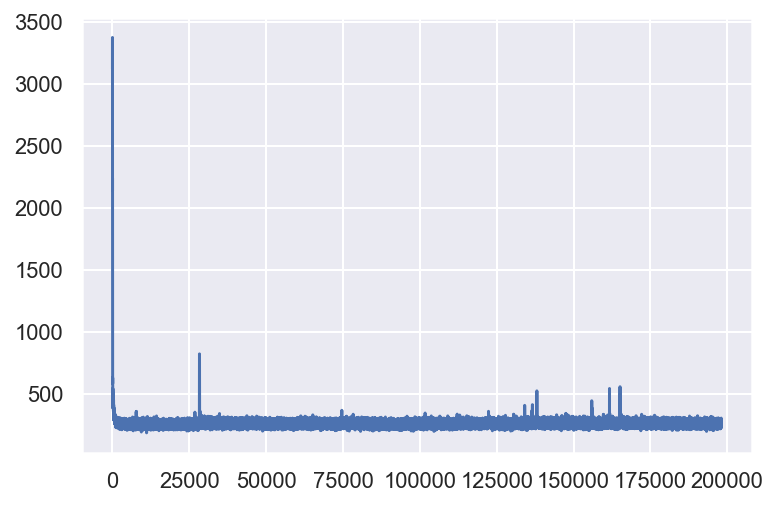

  0%|          | 0/5000 [00:00<?, ?it/s]

In [18]:
z_flow, theta_flow, hist_loss = train(data_dict, batch_size=1000, n_sample=100,
                                      initial_lr=0.005, flow_length=40, n_epochs=5000)

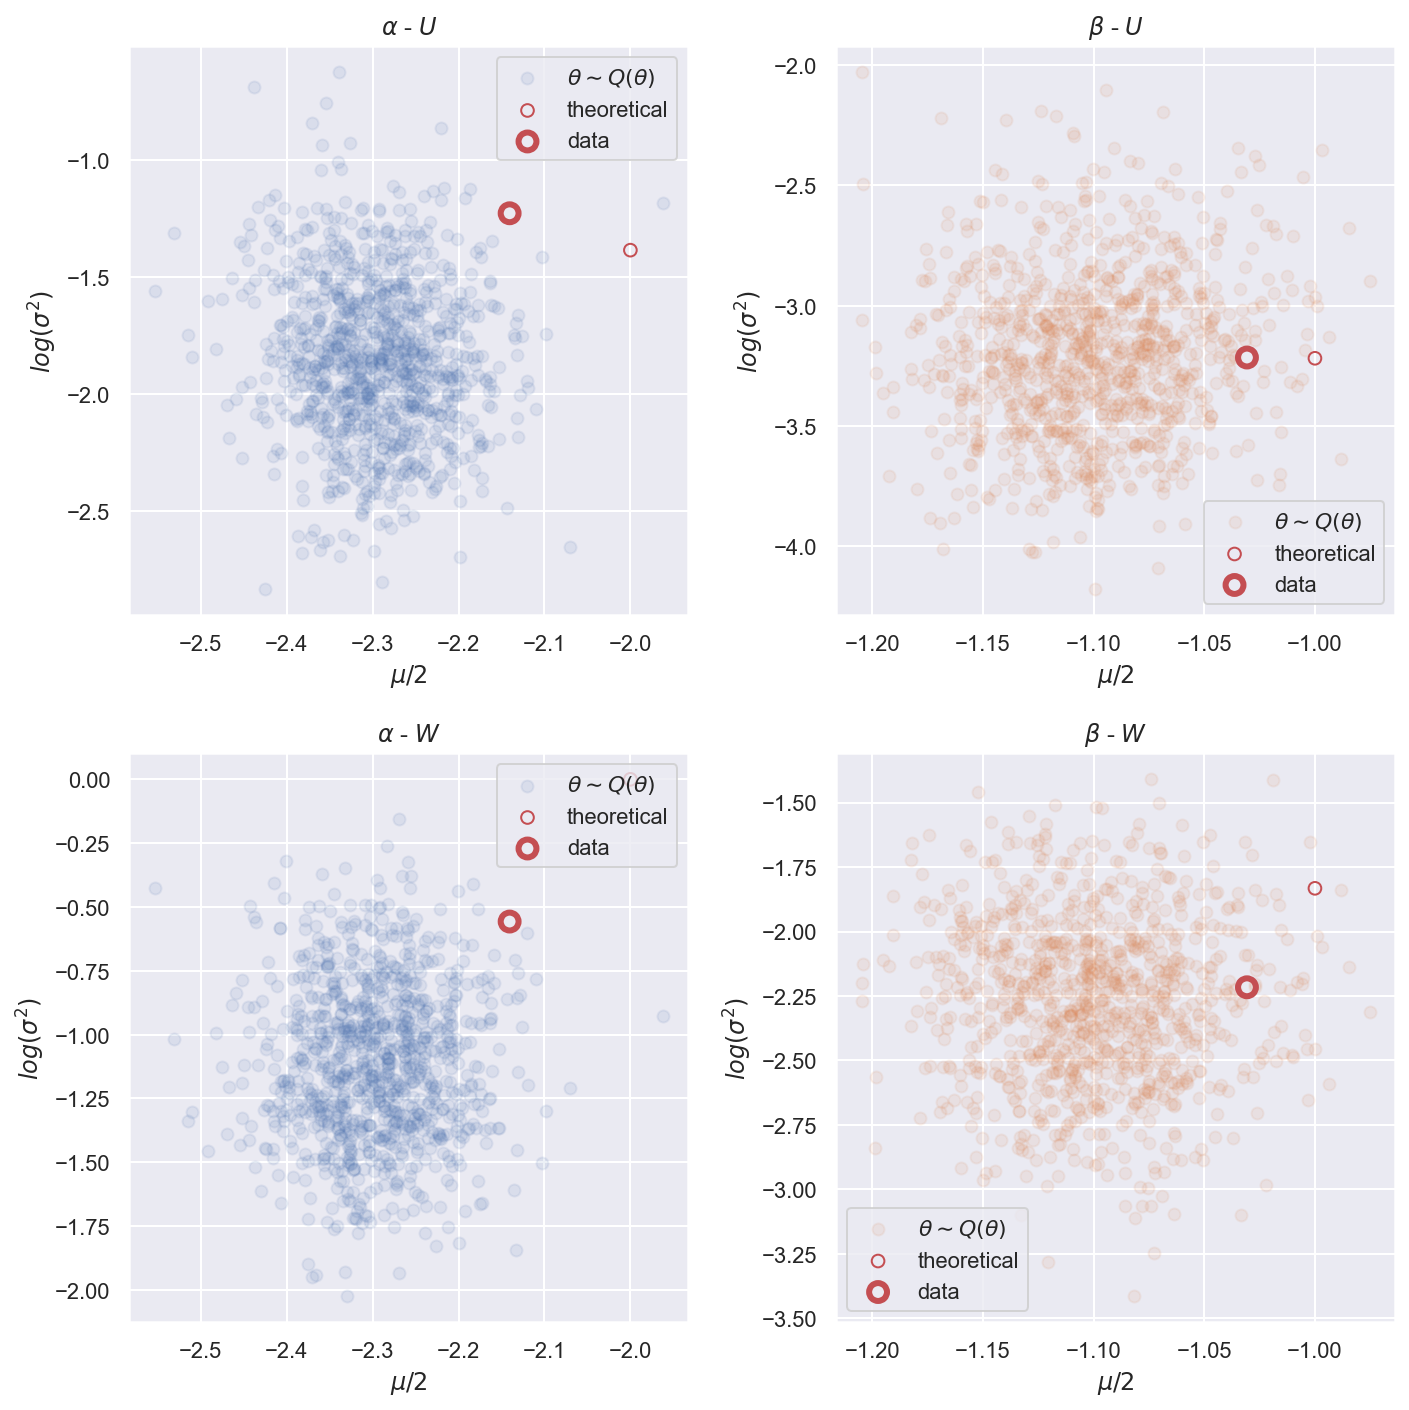

In [19]:
plot_posterior(theta_flow=theta_flow, 
               truth=truth, 
               name='artificial_mini_batch')

# Trash

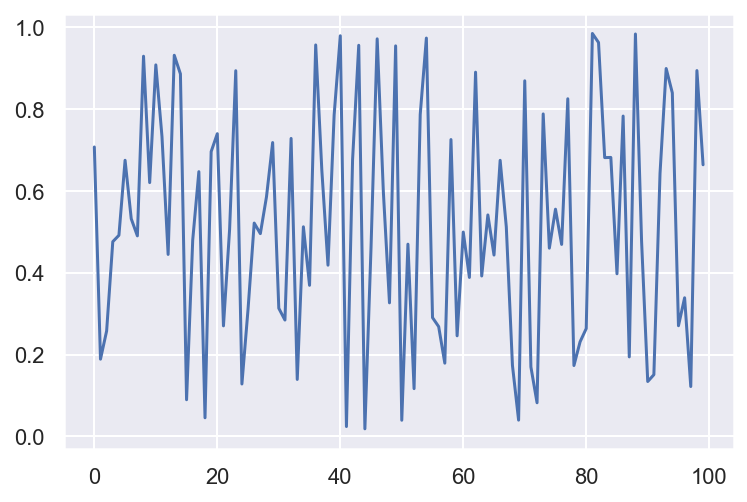

  0%|          | 0/100 [00:00<?, ?it/s]

In [72]:
fig, ax =plt.subplots()
line, = ax.plot([], [])
hdisplay = display.display(None, display_id=True)

for i in tqdm(range(100)):
    
    new_x = i
    new_y = np.random.random()
    line.set_xdata(np.append(line.get_xdata(), new_x))
    line.set_ydata(np.append(line.get_ydata(), new_y))
    ax.relim()
    ax.autoscale_view()
    
    hdisplay.update(fig)
    sleep(0.2)

plt.close(fig)

In [153]:
def plot_posterior(theta_flow, batch_size=1000, truth=None,
                   name=""):

    z0_θ = theta_flow.sample_base_dist(batch_size)
    zk_θ, prior_logprob_θ, log_det_θ = theta_flow(z0_θ)

    mu1, log_var_u1, log_var_w1 = zk_θ.data[:, :3].T
    mu2, log_var_u2, log_var_w2 = zk_θ.data[:, 3:].T

    fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

    alpha = 0.1

    ax = axes[0, 0]
    ax.set_title(r"$\alpha$ - $U$")
    ax.scatter(mu1, log_var_u1,
               color='C0', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")

    if truth is not None:
        ax.scatter(truth['mu'][0] / 2, np.log(truth['sg_u'][0] ** 2),
                   edgecolors='C3', alpha=1,
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][0] / 2, np.log(truth['sg_u_smp'][0] ** 2),
                   facecolors='none', edgecolors='C3', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[1, 0]
    ax.set_title(r"$\alpha$ - $W$")
    ax.scatter(mu1, log_var_w1,
               color='C0', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][0] / 2, np.log(truth['sg_w'][0] ** 2),
                   edgecolors='C3',
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][0] / 2, np.log(truth['sg_w_smp'][0] ** 2),
                   facecolors='none', edgecolors='C3', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[0, 1]
    ax.set_title(r"$\beta$ - $U$")
    ax.scatter(mu2, log_var_u2,
               color='C1', alpha=alpha, label=r"$\theta \sim Q(\theta)$")

    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][1] / 2, np.log(truth['sg_u'][1] ** 2),
                   edgecolors='C3',
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][1] / 2, np.log(truth['sg_u_smp'][1] ** 2),
                   facecolors='none', edgecolors='C3', s=80,
                   linewidths=3, label="data")
    ax.legend()

    ax = axes[1, 1]
    ax.set_title(r"$\beta$ - $W$")
    ax.scatter(mu2, log_var_w2,
               color='C1', alpha=alpha, label=r"$\theta \sim Q(\theta)$")
    ax.set_xlabel("$\mu /2$")
    ax.set_ylabel("$log(\sigma^2)$")
    if truth is not None:
        ax.scatter(truth['mu'][1] / 2, np.log(truth['sg_w'][1] ** 2),
                   edgecolors='C3', alpha=1,
                   label='theoretical', facecolors='none', s=40)
        ax.scatter(truth['mu_smp'][1] / 2, np.log(truth['sg_w_smp'][1] ** 2),
                   facecolors='none', edgecolors='C3', alpha=1, s=80,
                   linewidths=3, label="data")
    ax.legend()

    fig.tight_layout()

In [ ]:
# Actually 3 times slower to use pytorch 

In [177]:
class TeachingDataset(Dataset):
    def __init__(self, u, w, x, r, y):
        super().__init__()
        self.x = torch.from_numpy(x.reshape(-1, 1))
        self.y = torch.from_numpy(y.reshape(-1, 1))
        self.r = torch.from_numpy(r.reshape(-1, 1))
        self.u = u
        self.w = w
        
        self.n_u = len(np.unique(u))
        self.n_w = len(np.unique(w))
        self.n_obs = len(self.u)
        
    def __len__(self):
        return self.n_obs
        
    def __getitem__(self, idx):
        return {'x': self.x[idx], 
                'y': self.y[idx], 
                'r': self.r[idx], 
                'u': self.u[idx], 
                'w': self.w[idx]}


In [174]:
training_data = TeachingDataset(**data_dict)

In [175]:
n_u = training_data.n_u
n_w = training_data.n_w
n_obs = len(training_data.u)
print("N user", n_u)
print("N item", n_w)
print("N observation", n_obs)

N user 20
N item 20
N observation 40000


In [ ]:
dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)